<a href="https://colab.research.google.com/github/heugyu/coin_deep_learning/blob/master/DataPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
# 구글 드라이브 마운트 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib
import matplotlib.pyplot as plt

In [55]:
# 구글 드라이브 csv read
data = pd.read_csv('/content/drive/My Drive/DATA/BINANCE_BTCUSDT, 30.csv')
print(f'데이터 shape : {data.shape}')
data.head()

데이터 shape : (20457, 49)


,time,open,high,low,close,H,M,L,wca,RES,SUP,Shapes,Shapes.1,EMA_34,EMA_90,EMA_100,EMA_144,EMA_200,short_line,RES.1,RES_CLOSE,SUP.1,SUP_CLOSE,VWAP,34 EMA,Volume,Volume MA,Bitfinex (USD),Coinbase (USD),Bitstamp (USD),Kraken (USD),HitBTC (USD),CEX.io (USD),Binance (USDT),Bittrex (USDT),Poloniex (USDT),bitFlyer (JPY),Bithumb (KRW),Korbit (KRW),Kraken (EUR),Bitfinex (EUR),Bitstamp (EUR),Coinbase (EUR),Volume.1,A/D Volume,Volume EMA,A/D Volume EMA,A/D Buy MA,A/D Sell MA
0,1546300800,3701.23,3703.72,3689.88,3694.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3695.933333,3747.319315,322.716816,NaN,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,7.277674e+07,0.000000e+00,NaN,NaN,NaN,NaN
1,1546302600,3693.96,3713.00,3693.00,3700.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3699.202317,3747.319315,363.650604,NaN,293265.548412,4.905579e+05,55599.891894,101401.563275,6.256120e+05,4721.332087,578859.756320,709500.031334,13555.986530,164492.536833,44019.496881,13917.635647,0.0,0.0,0.0,0.0,8.162056e+07,3.645190e+08,NaN,NaN,NaN,NaN
2,1546304400,3700.20,3702.73,3691.22,3699.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3698.781904,3747.319315,275.191465,NaN,23383.892564,5.151579e+05,63347.057885,53173.586629,1.105990e+05,1194.206875,275921.138045,589702.559597,490.436390,135582.245094,11383.580919,6382.902702,0.0,0.0,0.0,0.0,8.406477e+07,2.487707e+08,NaN,NaN,NaN,NaN
3,1546306200,3699.08,3700.00,3684.22,3689.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3696.835336,3744.026211,338.347650,NaN,410822.308402,1.044291e+06,64155.479063,136715.379235,1.523040e+06,6895.989269,797655.454961,657379.636085,1937.348583,108666.368200,92445.143552,46392.131513,0.0,0.0,0.0,0.0,1.040063e+08,6.018173e+08,NaN,NaN,NaN,NaN
4,1546308000,3689.67,3695.95,3675.04,3686.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3693.706328,3744.026211,519.488423,NaN,150882.835199,1.187962e+05,146553.666400,110887.171512,4.401011e+05,300.498169,493953.540195,790138.887097,4415.778053,57875.411815,25785.704202,7209.289655,0.0,0.0,0.0,0.0,8.810869e+07,2.561461e+08,NaN,NaN,NaN,NaN


#### pandas 
- dataframe.shape -> 행열의 개수 
- dataframe.index -> 행이 어떻게 이루어져 있는지 
- dataframe.columns -> 열이 어떻게 이루어져 있는지  

In [56]:
data[['time', 'open', 'high', 'low', 'close']].head()

,time,open,high,low,close
0,1546300800,3701.23,3703.72,3689.88,3694.20
1,1546302600,3693.96,3713.00,3693.00,3700.31
2,1546304400,3700.20,3702.73,3691.22,3699.25
3,1546306200,3699.08,3700.00,3684.22,3689.69
4,1546308000,3689.67,3695.95,3675.04,3686.64


In [57]:
# UNIX TIME CONVERT
data.time = pd.to_datetime(data.time, format='%Y-%m-%d %H:%M:%S')
# Describe 
# 기본 데이터 이외에는 NaN 값 존재 na를 제거 해야함 
data.describe()

,open,high,low,close,H,M,L,wca,RES,SUP,Shapes,Shapes.1,EMA_34,EMA_90,EMA_100,EMA_144,EMA_200,short_line,RES.1,RES_CLOSE,SUP.1,SUP_CLOSE,VWAP,34 EMA,Volume,Volume MA,Bitfinex (USD),Coinbase (USD),Bitstamp (USD),Kraken (USD),HitBTC (USD),CEX.io (USD),Binance (USDT),Bittrex (USDT),Poloniex (USDT),bitFlyer (JPY),Bithumb (KRW),Korbit (KRW),Kraken (EUR),Bitfinex (EUR),Bitstamp (EUR),Coinbase (EUR),Volume.1,A/D Volume,Volume EMA,A/D Volume EMA,A/D Buy MA,A/D Sell MA
count,20457.000000,20457.000000,20457.000000,20457.000000,20439.000000,20429.000000,20439.000000,0.0,0.0,0.0,0.0,0.0,20424.000000,20368.000000,20358.000000,20314.000000,20258.000000,20423.000000,20457.000000,20457.000000,20457.000000,20457.000000,20457.000000,20457.000000,20457.000000,20438.000000,2.045700e+04,2.045700e+04,2.045700e+04,2.045700e+04,2.045700e+04,2.045700e+04,2.045700e+04,2.045700e+04,2.045700e+04,2.045700e+04,2.045700e+04,2.045700e+04,2.045700e+04,2.045700e+04,2.045700e+04,2.045700e+04,2.045700e+04,2.045700e+04,2.045100e+04,2.045100e+04,1.052900e+04,9.915000e+03
mean,7586.935710,7611.892566,7560.104324,7587.168692,7811.293832,7585.678113,7356.293426,NaN,NaN,NaN,NaN,NaN,7589.330187,7592.987286,7593.631996,7596.509258,7600.110886,7592.758180,7777.563299,7756.280104,7324.822832,7351.460053,6315.108712,7570.996746,917.881532,917.668291,7.210491e+05,8.982261e+05,5.362103e+05,4.316231e+05,1.447284e+06,1.395061e+04,3.047026e+06,3.061884e+06,8.927909e+04,3.492064e+05,4.251172e+05,3.838382e+04,3.377680e+05,6.000029e+04,1.033062e+05,1.213342e+05,3.399060e+08,2.056004e+09,3.398805e+08,2.056138e+09,2.053414e+09,2.057959e+09
std,2527.783001,2540.584881,2513.472677,2527.648037,2643.426881,2524.886990,2415.013050,NaN,NaN,NaN,NaN,NaN,2523.835323,2517.736710,2516.699949,2512.061904,2506.045773,2529.469694,2659.816068,2648.170626,2413.863467,2426.400347,1902.275198,2524.219049,945.752573,560.099814,2.388080e+06,2.417965e+06,1.263408e+06,1.801308e+06,2.484545e+06,5.050927e+04,5.365308e+06,5.354771e+06,2.058486e+05,7.205569e+05,1.764531e+06,2.083111e+06,8.850693e+05,2.197695e+05,2.680098e+05,3.632747e+05,4.224836e+08,4.004946e+09,3.086705e+08,2.402705e+09,1.996777e+09,2.060770e+09
min,3366.630000,3374.990000,3349.920000,3366.410000,3431.985979,3403.893262,3352.922161,NaN,NaN,NaN,NaN,NaN,3400.027777,3409.091568,3410.687817,3417.211680,3423.959938,1528.711578,0.000000,0.000000,0.000000,0.000000,3619.538664,3415.962794,20.361211,193.573744,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.067346e+07,0.000000e+00,2.860859e+07,5.623169e+07,1.417819e+08,1.049404e+08
25%,5218.820000,5231.770000,5205.780000,5218.850000,5334.678516,5214.854547,5076.571729,NaN,NaN,NaN,NaN,NaN,5231.251896,5218.324291,5215.814766,5216.176279,5229.621809,5234.085951,5295.000000,5281.980000,5085.750000,5110.750000,4033.775649,5172.390716,410.908998,539.808628,5.699344e+04,1.002173e+05,6.082020e+04,4.337557e+04,1.973814e+05,1.051933e+03,5.754704e+05,5.879467e+05,5.360551e+03,4.220894e+04,4.038954e+04,1.521125e+03,3.612587e+04,4.218482e+03,9.512723e+03,1.060500e+04,1.246021e+08,3.469637e+08,1.499270e+08,7.288055e+08,8.225875e+08,8.355240e+08
50%,8068.100000,8093.930000,8040.470000,8069.390000,8270.388891,8063.920667,7842.228619,NaN,NaN,NaN,NaN,NaN,8071.898777,8069.561797,8074.966233,8081.491712,8094.355629,8078.202793,8264.290000,8246.600000,7773.000000,7804.990000,7260.993723,8069.459161,635.168999,762.304648,1.828678e+05,2.804163e+05,1.762243e+05,1.362143e+05,6.580660e+05,3.412613e+03,1.433583e+06,1.463116e+06,2.315444e+04,1.281803e+05,1.241026e+05,5.901425e+03,1.177889e+05,1.480240e+04,3.207149e+04,3.584125e+04,2.211878e+08,9.124117e+08,2.546388e+08,1.349804e+09,1.483989e+09,1.482157e+09
75%,9604.960000,9634.110000,9572.130000,9604.700000,9899.886788,9634.288440,9362.375166,NaN,NaN,NaN,NaN,NaN,9606.857301,9653.609129,9656.836928,9680.006916,9708.71

In [0]:
# 일단, 기본 정보만 출려
test_data = data[['open', 'high', 'low', 'close']]
test_label = data[['close']]

In [59]:
# MINMAX Scale 적용 가격은 전체에 스케일러 1개만 있으면 될듯 
price_scaler = MinMaxScaler()
price_scaler.fit(np.array(test_data).reshape(-1, 1))
test_data['open'] = price_scaler.transform(np.array(test_data[['open']]).reshape(-1, 1))
test_data['high'] = price_scaler.transform(np.array(test_data[['high']]).reshape(-1, 1))
test_data['low'] = price_scaler.transform(np.array(test_data[['low']]).reshape(-1, 1))
test_data['close'] = price_scaler.transform(np.array(test_data[['close']]).reshape(-1, 1))
# test_data = pd.DataFrame(price_scaler.fit_transform(test_data), columns=test_data.columns)
test_data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

,open,high,low,close
0,0.033080,0.033314,0.032011,0.032418
1,0.032395,0.034188,0.032305,0.032993
2,0.032983,0.033221,0.032137,0.032893
3,0.032877,0.032964,0.031478,0.031993
4,0.031991,0.032583,0.030614,0.031706
...,...,...,...,...
20452,0.513011,0.513011,0.507212,0.509511
20453,0.509395,0.509766,0.504054,0.507201
20454,0.507203,0.521177,0.501459,0.504866
20455,0.504866,0.510362,0.503770,0.508762


In [60]:
test_label

,close
0,3694.20
1,3700.31
2,3699.25
3,3689.69
4,3686.64
...,...
20452,8760.97
20453,8736.43
20454,8711.64
20455,8753.01


In [0]:
x = np.array(test_data)
y = np.array(test_data[['close']])

In [0]:
# 파라미터
INPUT_SIZE = 4     # input dimension
HIDDEN_SIZE = 8    # hidden dimension
BATCH_SIZE = 2
LENGTH = 7
LR = 0.01
EPOCHS = 500

In [0]:
dataX = []
dataY = []

for i in range(0, len(y) - LENGTH):
    _x = x[i:i + LENGTH]
    _y = y[i + LENGTH]
    # print(f'{_x} -> {_y}')
    dataX.append(_x)
    dataY.append(_y)

# train/test split 
train_size = int(len(dataY) * 0.9)
test_size = len(dataY) - train_size

trainX = torch.Tensor(np.array(dataX[0:train_size]))
trainX = Variable(trainX)
testX = torch.Tensor(np.array(dataX[train_size:len(dataX)]))
testX = Variable(testX)

trainY = torch.Tensor(np.array(dataY[0:train_size]))
trainY = Variable(trainY)
testY = torch.Tensor(np.array(dataY[train_size:len(dataY)]))
testY = Variable(testY)


In [64]:
print(trainX.shape)
print(trainY.shape)

print(testX.shape)
print(testY.shape)

torch.Size([18405, 7, 4])
torch.Size([18405, 1])
torch.Size([2045, 7, 4])
torch.Size([2045, 1])


In [0]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(
                input_size=input_size, 
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True
                )
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Intitialize hidden and cell states
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

        # Propagte inpur through LSTM
        _, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        return out


In [66]:
# Instantiate RNN model
lstm = LSTM(1, INPUT_SIZE, HIDDEN_SIZE, 1, LENGTH)

# Set loss and optimizer function
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr=LR)

# Train the model
for epoch in range(EPOCHS):
    outputs = lstm(trainX)
    optimizer.zero_grad()

    #obtain the loss function
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    print(f'Epoch : {epoch}, loss : {loss.data.item()}')


Epoch : 0, loss : 0.18611203134059906
Epoch : 1, loss : 0.14842167496681213
Epoch : 2, loss : 0.115763820707798
Epoch : 3, loss : 0.08774955570697784
Epoch : 4, loss : 0.06422610580921173
Epoch : 5, loss : 0.04559309035539627
Epoch : 6, loss : 0.032880086451768875
Epoch : 7, loss : 0.027304232120513916
Epoch : 8, loss : 0.028794752433896065
Epoch : 9, loss : 0.033968910574913025
Epoch : 10, loss : 0.03795027732849121
Epoch : 11, loss : 0.038144394755363464
Epoch : 12, loss : 0.03469914570450783
Epoch : 13, loss : 0.029144637286663055
Epoch : 14, loss : 0.02318182960152626
Epoch : 15, loss : 0.01804915815591812
Epoch : 16, loss : 0.014331233687698841
Epoch : 17, loss : 0.012040329165756702
Epoch : 18, loss : 0.010829969309270382
Epoch : 19, loss : 0.010216851718723774
Epoch : 20, loss : 0.00973918754607439
Epoch : 21, loss : 0.009045513346791267
Epoch : 22, loss : 0.007938958704471588
Epoch : 23, loss : 0.006396810989826918
Epoch : 24, loss : 0.004569724202156067
Epoch : 25, loss : 0.00

Learning finished!


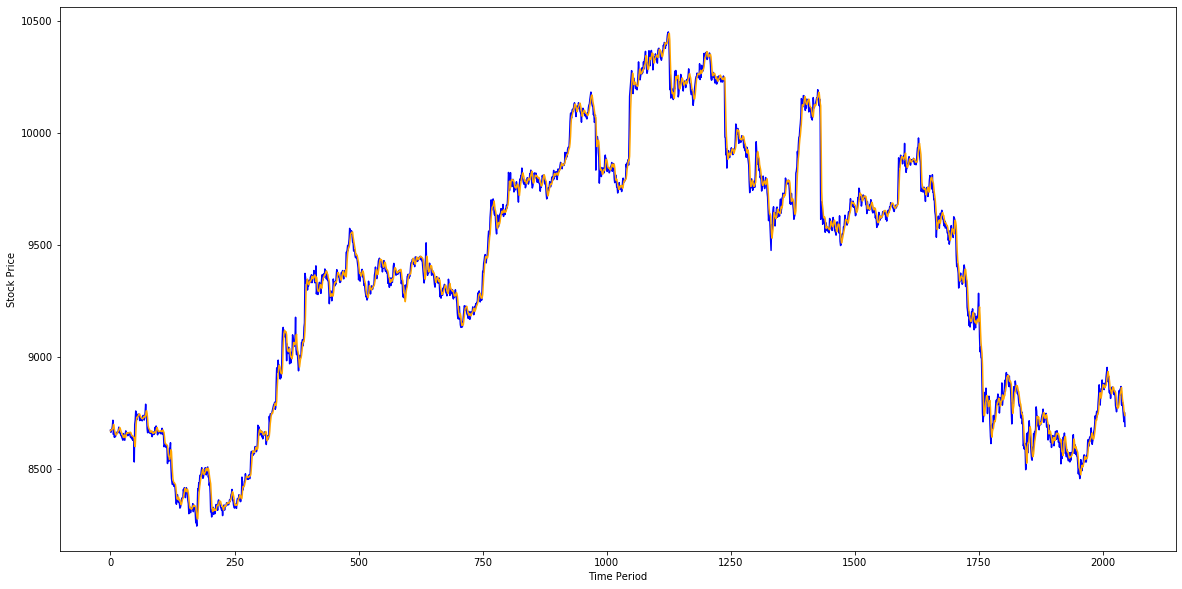

In [69]:
print("Learning finished!")
# Test the model
lstm.eval()
test_predict = lstm(testX)

# Plot predictions
test_predict = test_predict.data.numpy()
test_predict = price_scaler.inverse_transform(test_predict) 
testY_real = price_scaler.inverse_transform(testY.data.numpy())
plt.figure(figsize=(20, 10))
plt.plot(testY_real, color='b')
plt.plot(test_predict, color='orange')
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()